In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# format display 
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

# global random state
random_state = 0

In [2]:
# read in the data
root = 'data/'
df = pd.read_csv(root + 'single_user_1.csv')
events = pd.read_csv(root + 'train_events.csv')

# Feature creation

In [3]:
# anglez
df['anglez_diff'] = df['anglez'].diff()
df['anglez_diff'] = df['anglez_diff'].fillna(0)

df['anglez_rolling_mean'] = df['anglez'].rolling(window=61, min_periods=1).mean()
df['anglez_rolling_std'] = df['anglez'].rolling(window=61, min_periods=1).std()
df['anglez_rolling_std'] = df['anglez_diff'].fillna(0)



# enmo
df['enmo_diff'] = df['enmo'].diff()
df['enmo_diff'] = df['enmo_diff'].fillna(0)

df['enmo_rolling_mean'] = df['enmo'].rolling(window=61, min_periods=1).mean()
df['enmo_rolling_std'] = df['enmo'].rolling(window=61, min_periods=1).std()
df['enmo_rolling_std'] = df['anglez_diff'].fillna(0)

In [4]:
# check
df.head()

,series_id,step,anglez,enmo,date,asleep,anglez_diff,anglez_rolling_mean,anglez_rolling_std,enmo_diff,enmo_rolling_mean,enmo_rolling_std
0,038441c925bb,3240,67.175,0.015,2018-08-15,0,0.000,67.175,0.000,0.000,0.015,0.000
1,038441c925bb,3241,68.881,0.021,2018-08-15,0,1.706,68.028,1.706,0.006,0.018,1.706
2,038441c925bb,3242,73.114,0.034,2018-08-15,0,4.233,69.723,4.233,0.013,0.024,4.233
3,038441c925bb,3243,73.692,0.030,2018-08-15,0,0.578,70.715,0.578,-0.004,0.025,0.578
4,038441c925bb,3244,72.685,0.020,2018-08-15,0,-1.007,71.109,-1.007,-0.011,0.024,-1.007


# Model 1

In [5]:
# create features and target
X = df.drop(['series_id', 'asleep', 'step', 'date'], axis=1)
y = df['asleep']

In [6]:
# create pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('logreg', LogisticRegression(n_jobs=-1, random_state=random_state))])

In [7]:
# cross validate
scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')

# print results
scores, scores.mean()

(array([0.78894067, 0.83249574, 0.7408778 , 0.78022965, 0.78140229]),
 0.7847892300194931)

In [8]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# fit pipeline
pipe.fit(X_train, y_train)

# get preds
preds = pipe.predict(X_test)


print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83     41789
           1       0.70      0.74      0.72     23875

    accuracy                           0.79     65664
   macro avg       0.77      0.78      0.78     65664
weighted avg       0.79      0.79      0.79     65664



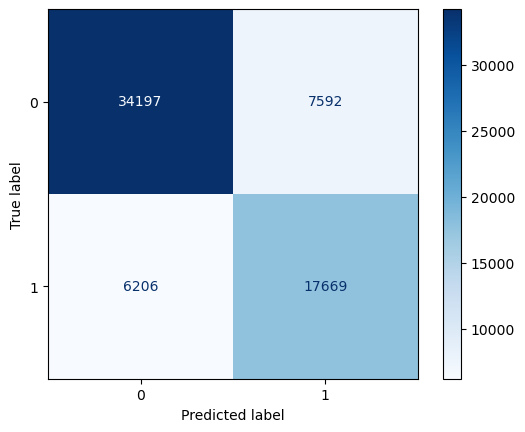

In [9]:
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap='Blues');

# Visualize preds

In [10]:
# copy df, add preds
df_copy = df.copy()
df_copy['pred'] = pipe.predict(X)

# check
df_copy.head()

,series_id,step,anglez,enmo,date,asleep,anglez_diff,anglez_rolling_mean,anglez_rolling_std,enmo_diff,enmo_rolling_mean,enmo_rolling_std,pred
0,038441c925bb,3240,67.175,0.015,2018-08-15,0,0.000,67.175,0.000,0.000,0.015,0.000,0
1,038441c925bb,3241,68.881,0.021,2018-08-15,0,1.706,68.028,1.706,0.006,0.018,1.706,0
2,038441c925bb,3242,73.114,0.034,2018-08-15,0,4.233,69.723,4.233,0.013,0.024,4.233,0
3,038441c925bb,3243,73.692,0.030,2018-08-15,0,0.578,70.715,0.578,-0.004,0.025,0.578,0
4,038441c925bb,3244,72.685,0.020,2018-08-15,0,-1.007,71.109,-1.007,-0.011,0.024,-1.007,0


In [11]:
# look at rows where prediction switches from 0 to 1 or 1 to 0
df_copy["pred_switch"] = (df_copy["pred"].diff() != 0).astype(int)

In [12]:
df_copy["pred_switch"].value_counts()

pred_switch
0    326251
1      2069
Name: count, dtype: int64

- For this user, we have 19 valid nights of data, meaning a perfect model would have 38 rows where sleep state switched.
- Currently, our model has over 2000. This is because at any given 5-second timestep, our model is predicting whether the user is asleep or awake at that given moment. This would include times in the night where the user briefly woke up.
- We want to identify the sleep window, and return the step where it began and where it ended on each day.

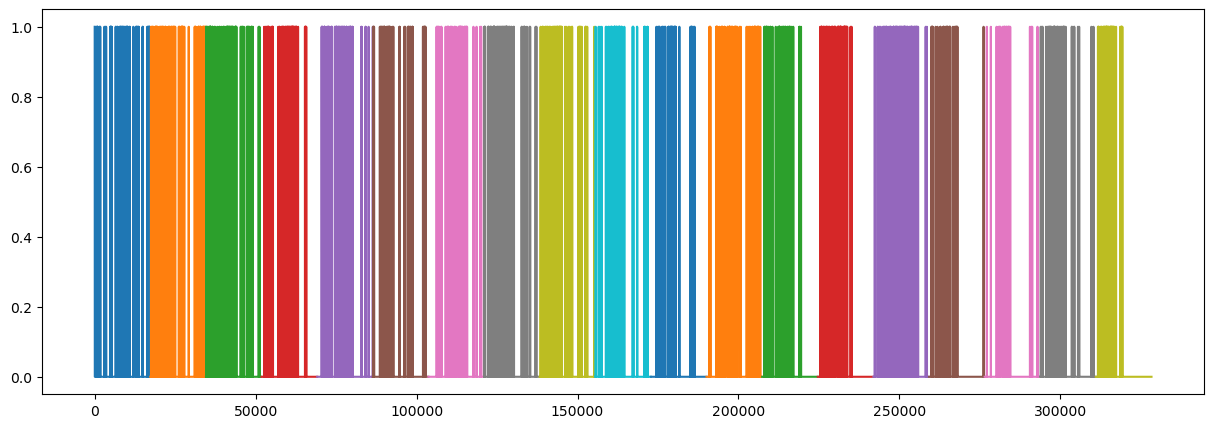

In [14]:
# plot pred switch for each date
for date, row in df_copy.groupby('date'):
    row['pred_switch'].plot(figsize=(15, 5));

In [121]:
df_copy.query("pred_switch == 1 & pred == 1")

,series_id,step,anglez,enmo,date,asleep,pred,pred_switch
527,038441c925bb,3767,-72.244,0.019,2018-08-15,0,1,1
675,038441c925bb,3915,-18.482,0.012,2018-08-15,0,1,1
861,038441c925bb,4101,-43.264,0.016,2018-08-15,0,1,1
899,038441c925bb,4139,-13.043,0.030,2018-08-15,0,1,1
901,038441c925bb,4141,-56.729,0.020,2018-08-15,0,1,1
...,...,...,...,...,...,...,...,...
318868,038441c925bb,373948,-8.412,0.013,2018-09-05,0,1,1
318927,038441c925bb,374007,-34.154,0.018,2018-09-05,0,1,1
318967,038441c925bb,374047,-35.989,0.018,2018-09-05,0,1,1
318969,038441c925bb,374049,-35.822,0.019,2018-09-05,0,1,1


In [130]:
predicted_onset = df_copy.query("pred_switch == 1 & pred == 1").groupby("date")['step'].min()
predicted_wakeup = df_copy.query("pred_switch == 1 & pred == 0").groupby("date")['step'].min()

# True Labels

In [136]:
# first user
example_user = '038441c925bb'

# get labels for user
labels = events.dropna()[events['series_id'] == example_user].reset_index(drop=True)

C:\Users\heefj\AppData\Local\Temp\ipykernel_20728\4097891560.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  labels = events.dropna()[events['series_id'] == example_user].reset_index(drop=True)


In [154]:
labels

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.000,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.000,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.000,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.000,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.000,2018-08-16T23:03:00-0400
5,038441c925bb,3,wakeup,44400.000,2018-08-17T05:10:00-0400
6,038441c925bb,4,onset,57240.000,2018-08-17T23:00:00-0400
7,038441c925bb,4,wakeup,62856.000,2018-08-18T06:48:00-0400
8,038441c925bb,6,onset,91296.000,2018-08-19T22:18:00-0400
9,038441c925bb,6,wakeup,97860.000,2018-08-20T07:25:00-0400


In [126]:
# steps in a day
86400 / 5

17280.0

# Modeling Process

- Create features that indicate inactive accelerometer (value counts > 2)
- Create a model to identify unworn periods of time

- Filter those windows out of training data
- Create a model to identify asleep/awake

# Next steps:
We have a model that predicts when a user is asleep with 93% accuracy. Goal is to create a model that predicts when sleep starts and ends.

- Create more features to further increase accuracy.
- Brainstorm ways to give model the correct number of switches it should generate.